# 1. Introdução

Nesse notebook iremos utilizar uma base de dados com algumas informações sobre suicídios nos países, para tentar entender fatores que influenciam nessa decisão.

# 2. Imports e Funções


In [ ]:
# Para evitar avisos que iriam atrapalhar a visualização de dados
from warnings import filterwarnings

filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)
filterwarnings("ignore", category=RuntimeWarning)

# Pacote de ML utilizado
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score

# Ferramentas Estatísticas
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats as ss

# Pacote básico de manipulação e visualização de dados
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import cm

pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Padronização dos gráficos para facilitar visualização.

In [ ]:
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (16, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

Força o gráfica a ser desenhado no próprio notebook.

In [ ]:
plt.ion()

Função que retira as linhas das bordas direita e superior dos gráficos.

In [ ]:
def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

Função que calcula o bootstrap com 5000 valores do conjunto de dados x passado.

In [ ]:
def bootstrap_mean(x, n=5000):
    size = len(x)
    values = np.zeros(n)
    for i in range(n):
        sample = np.random.choice(x, size=size, replace=True)
        values[i] = sample.mean()
    return values

Função que calcula o bootstrap com 5000 valores do MSE (Erro Médio Quadrado) do modelo passado.

In [ ]:
def bootstrap_mse(X, y, model, n=5000):
    size = len(y)
    values = np.zeros(n)
    for i in range(n):
        idx = np.random.choice(size, size)
        Xb = X.iloc[idx]
        yb = y.iloc[idx]
        values[i] = mean_squared_error(yb, model.predict(Xb))
    return values

Função que calcula o bootstrap com 5000 valores do score do modelo passado. Ela não será utilizada nesse notebook, mas pode ser útil caso o leitor queira utilizar outra métrica para avaliar os modelos.

In [ ]:
def bootstrap_score(X, y, model, n=5000):
    size = len(y)
    values = np.zeros(n)
    for i in range(n):
        idx = np.random.choice(size, size)
        Xb = X.iloc[idx]
        yb = y.iloc[idx]
        values[i] = model.score(Xb, yb)
    return values

# 3. Base de Dados

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CSVs/Pokemon.csv', encoding='utf-8', sep=',')

In [ ]:
df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


## 1. Visualização Inicial


Somente a coluna 'HDI' possui NaNs. Iremos lidar com esse problema em um momento mais oportuno.

In [ ]:
df.isna().sum().sort_values(ascending=False)

Type 2        386
Legendary       0
Generation      0
Speed           0
Sp. Def         0
Sp. Atk         0
Defense         0
Attack          0
HP              0
Total           0
Type 1          0
Name            0
#               0
dtype: int64

In [ ]:
df.shape

(800, 13)

Suicídio por idade.

In [ ]:
df['Legendary'] = df['Legendary'] * 1 

In [ ]:
df['Total'].mean()

435.1025

In [ ]:
df[['Legendary', 'Total']].groupby(by='Legendary').mean().sort_values(by='Total')

,Total
Legendary,
0,417.213605
1,637.384615


In [ ]:
df[['Generation', 'Total']].groupby(by='Generation').mean().sort_values(by='Total')

,Total
Generation,
2,418.283019
1,426.813253
5,434.987879
3,436.225000
6,436.378049
4,459.016529


In [ ]:
df[['Generation', 'Legendary', 'Total']].groupby(by=['Legendary', 'Generation']).mean().sort_values(by='Total')

Total
Legendary Generation            
0         2           408.297030
          3           409.267606
          6           414.094595
          5           416.620000
          1           417.943750
          4           437.879630
1         5           618.666667
          2           620.000000
          4           634.615385
          6           642.500000
          3           648.888889
          1           663.333333

In [ ]:
df[['Type 1', 'Total']].groupby(by='Type 1').mean().sort_values(by='Total')

,Total
Type 1,
Bug,378.927536
Poison,399.142857
Normal,401.683673
Fairy,413.176471
Fighting,416.444444
Grass,421.142857
Water,430.455357
Ice,433.458333
Ground,437.500000


In [ ]:
df[['Type 2', 'Total']].groupby(by='Type 2').mean().sort_values(by='Total')

,Total
Type 2,
Bug,393.333333
Poison,396.500000
Grass,408.920000
Normal,411.500000
Fairy,417.956522
Water,418.214286
Ghost,430.714286
Rock,434.642857
Ground,444.342857


In [ ]:
df[['Type 1', 'Type 2', 'Total']].groupby(by=['Type 1', 'Type 2']).mean().sort_values(by='Total')[-15:]

Total
Type 1   Type 2              
Electric Dragon    610.000000
Water    Dragon    610.000000
Grass    Dragon    630.000000
Fire     Dragon    634.000000
Psychic  Fighting  638.666667
Dragon   Flying    641.666667
Rock     Dark      650.000000
Dragon   Psychic   650.000000
         Electric  680.000000
         Fire      680.000000
Steel    Dragon    680.000000
Psychic  Dark      680.000000
Ghost    Dragon    680.000000
Dragon   Ice       686.666667
Ground   Fire      770.000000

In [ ]:
# df['Type 1'].unique()

# 4. Visualização de Dados


## 2. Visualização da Expectativa de Vida

Da mesma maneira que o GDP, a distribuição da Expectativa de Vida não é simétrica, entretanto, a intensidade dessa assimetria é bem menor. Além do que, nesse caso, existem muitos países com a Expectativa de Vida parecida e relativamente alta, ao invés do contrário.

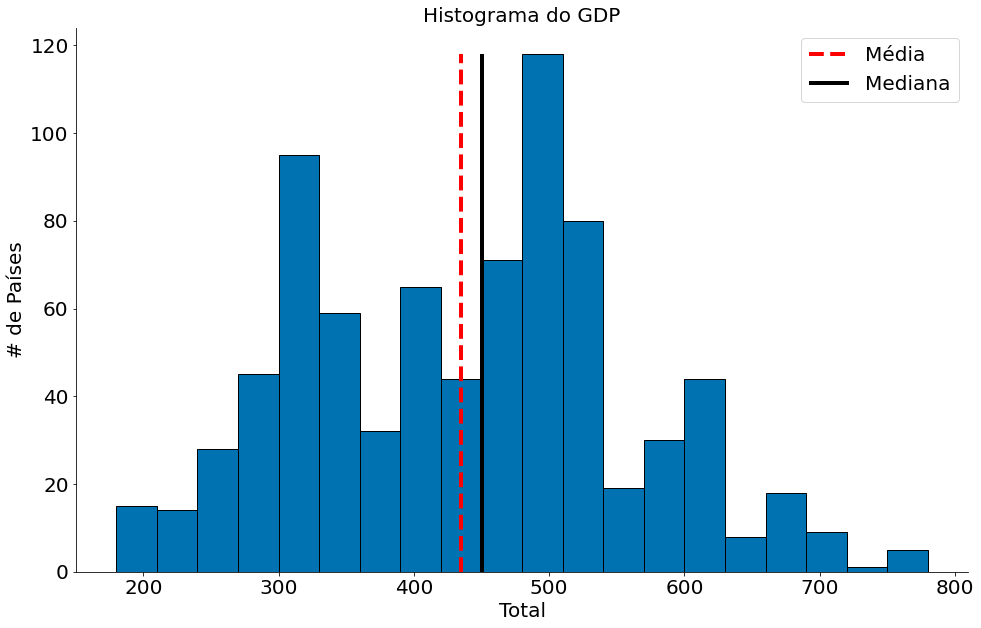

In [ ]:
col = 'Total'
# col = 'HP'
# col = 'Attack'
# col = 'Defense'
# col = 'Sp. Atk'
# col = 'Sp. Def' # Surpreendentemente parece uma normal
# col = 'Speed' # Surpreendentemente parece uma normal
# col = 'Generation'
# col = 'Legendary'

x = df[col]

ymin = 0

n, bins, patches = plt.hist(x, bins=20, edgecolor='k')
plt.vlines(x.mean(), ymin, n.max(), label='Média', linestyles='--', edgecolor='k', color='red')
plt.vlines(x.median(), ymin, n.max(), label='Mediana', color='black')
plt.xlabel(col)
plt.ylabel('# de Países')
plt.title('Histograma do GDP')

plt.legend()

despine()

plt.show()

# 5. Testes de Hipóteses

## 1. Testes da Expectativa de Vida

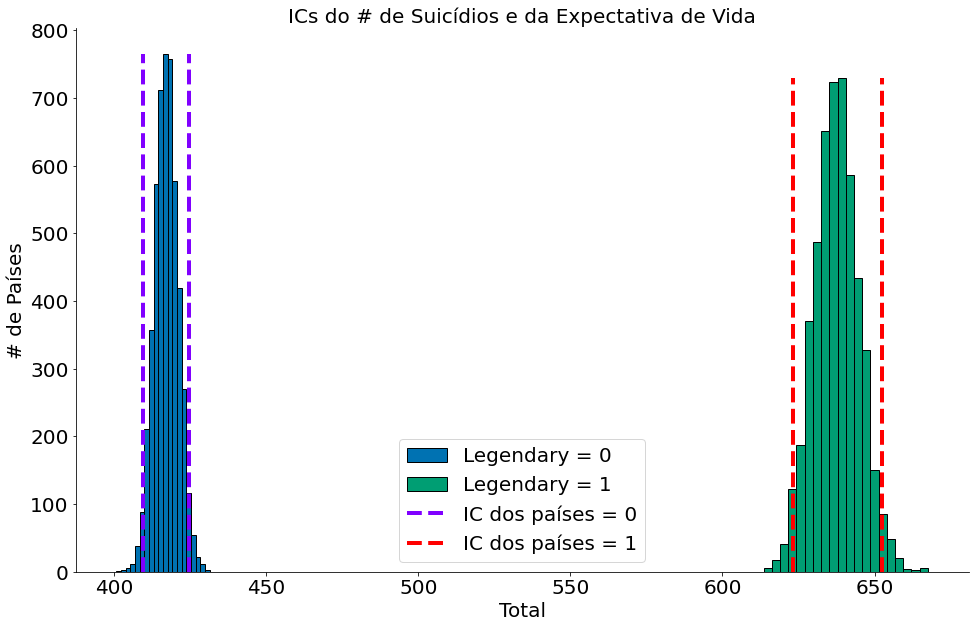

In [ ]:
ymin = 0
# colx = 'Type 1'
# colx = 'Type 2'
# colx = 'Generation'
colx = 'Legendary'

coly = 'Total'
# coly = 'HP'
# coly = 'Attack'
# coly = 'Defense'
# coly = 'Sp. Atk'
# coly = 'Sp. Def'
# coly = 'Speed'

corte = df[colx].unique()

color = iter(cm.rainbow(np.linspace(0, 1, len(corte))))

for i in corte:
    filtro = df[colx] == i
    df0 = df[coly][filtro]

    df0_mean = bootstrap_mean(df0)

    LI = np.percentile(df0_mean, 2.5)
    LS = np.percentile(df0_mean, 97.5)

    n, bins, patches = plt.hist(df0_mean, bins=20, edgecolor='k', label=colx + ' = ' + str(i))

    maior = n.max()

    c = next(color)

    plt.vlines(LI, ymin, maior, linestyles='--', label='IC dos países' + ' = ' + str(i), color=c)
    plt.vlines(LS, ymin, maior, linestyles='--', color=c)

plt.xlabel(coly)
plt.ylabel('# de Países')
plt.title('ICs do # de Suicídios e da Expectativa de Vida')

plt.legend()

despine()

plt.show()

O BoxPlot nos permite ver o mesmo que o último gráfico de uma forma diferente.

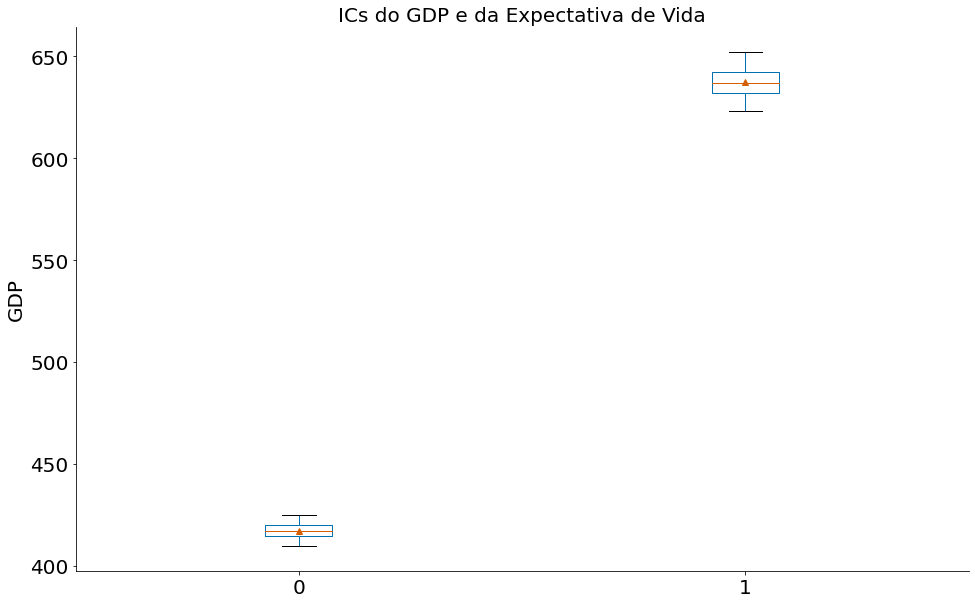

In [ ]:
corte = df[colx].unique()
df1 = pd.DataFrame()

for i in corte:
    filtro = df[colx] == i
    df0 = df[coly][filtro]

    df0_mean = bootstrap_mean(df0)

    df1[i] = df0_mean

df1.boxplot(grid=False, sym='', whis=[2.5, 97.5], showmeans=True)

plt.ylabel('GDP')
plt.title('ICs do GDP e da Expectativa de Vida')

despine()

plt.show()

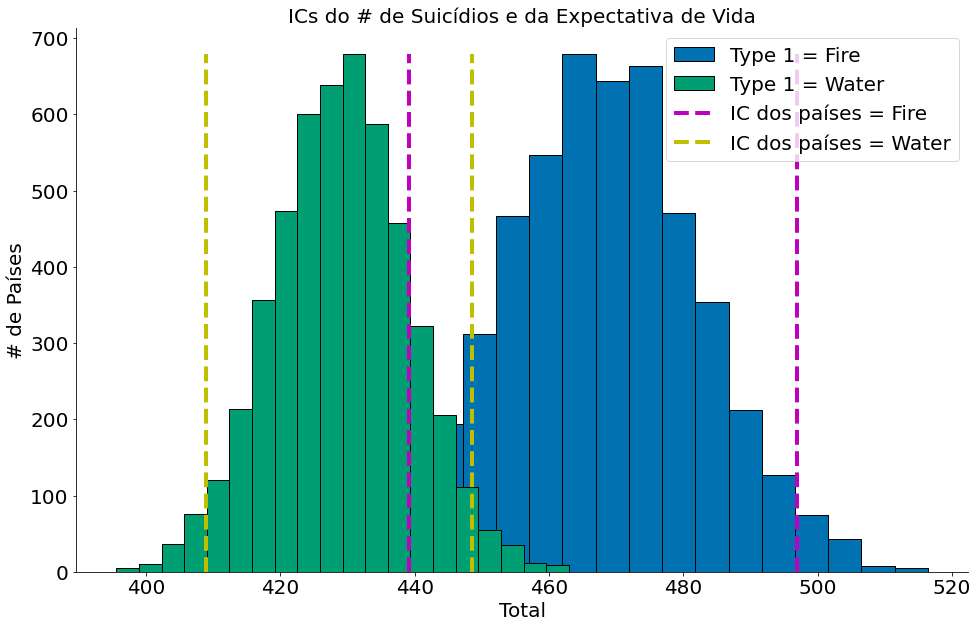

In [ ]:
colx = 'Type 1'

coly = 'Total'
# coly = 'HP'
# coly = 'Attack'
# coly = 'Defense'
# coly = 'Sp. Atk'
# coly = 'Sp. Def'
# coly = 'Speed'

corte = ['Fire', 'Water']

filtro = (df[colx] == corte[0]) | (df['Type 2'] == corte[0])
df0 = df[coly][filtro]

filtro = (df[colx] == corte[1]) | (df['Type 2'] == corte[1])
df1 = df[coly][filtro]

df0_mean = bootstrap_mean(df0)
df1_mean = bootstrap_mean(df1)

LI0 = np.percentile(df0_mean, 2.5)
LS0 = np.percentile(df0_mean, 97.5)
LI1 = np.percentile(df1_mean, 2.5)
LS1 = np.percentile(df1_mean, 97.5)

ymin = 0

maior = []

n, bins, patches = plt.hist(df0_mean, bins=20, edgecolor='k', label=colx + ' = ' + str(corte[0]))

maior.append(n.max())

n, bins, patches = plt.hist(df1_mean, bins=20, edgecolor='k', label=colx + ' = ' + str(corte[1]))

maior.append(n.max())

maior = np.max(maior)

plt.vlines(LI0, ymin, maior, linestyles='--', label='IC dos países' + ' = ' + str(corte[0]), color='m')
plt.vlines(LS0, ymin, maior, linestyles='--', edgecolor='m')
plt.vlines(LI1, ymin, maior, linestyles='--', label='IC dos países' + ' = ' + str(corte[1]), color='y')
plt.vlines(LS1, ymin, maior, linestyles='--', edgecolor='y')
plt.xlabel(coly)
plt.ylabel('# de Países')
plt.title('ICs do # de Suicídios e da Expectativa de Vida')

plt.legend()

despine()

plt.show()

O BoxPlot nos permite ver o mesmo que o último gráfico de uma forma diferente.

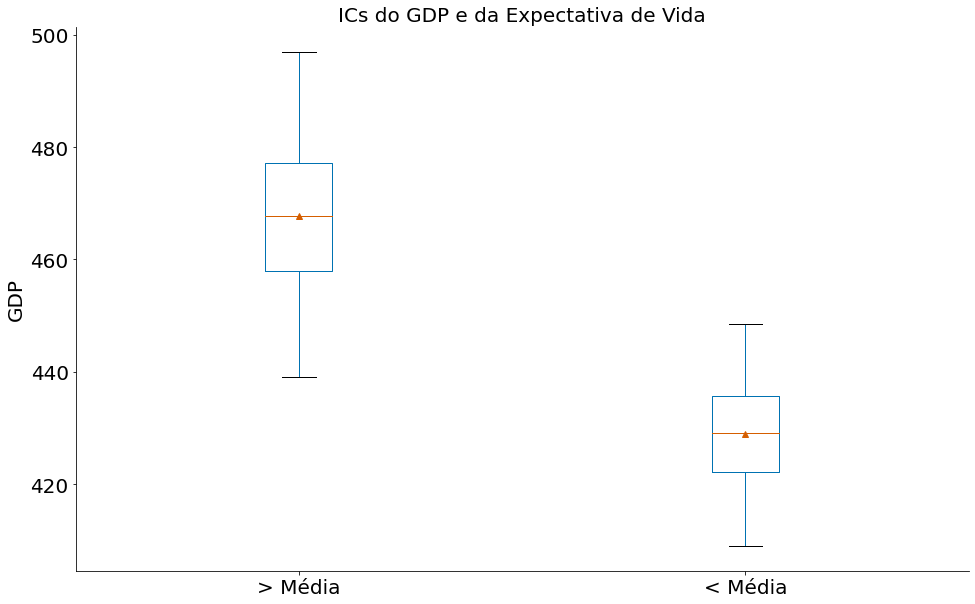

In [ ]:
df2 = pd.DataFrame()

df2['> Média'] = df0_mean
df2['< Média'] = df1_mean

df2.boxplot(grid=False, sym='', whis=[2.5, 97.5], showmeans=True)
plt.ylabel('GDP')
plt.title('ICs do GDP e da Expectativa de Vida')

despine()

plt.show()

### 5. Correlação entre Prevalência do HIV e Expectativa de Vida <a name="hivvida"></a>

Como esperado, parece existir uma correlação entre a Prevalência do HIV e a Expectativa de Vida de uma população. Esse dado é apenas uma curiosidade, já que estamos tentando ver quais fatores têm mais ou menos influência no GDP.

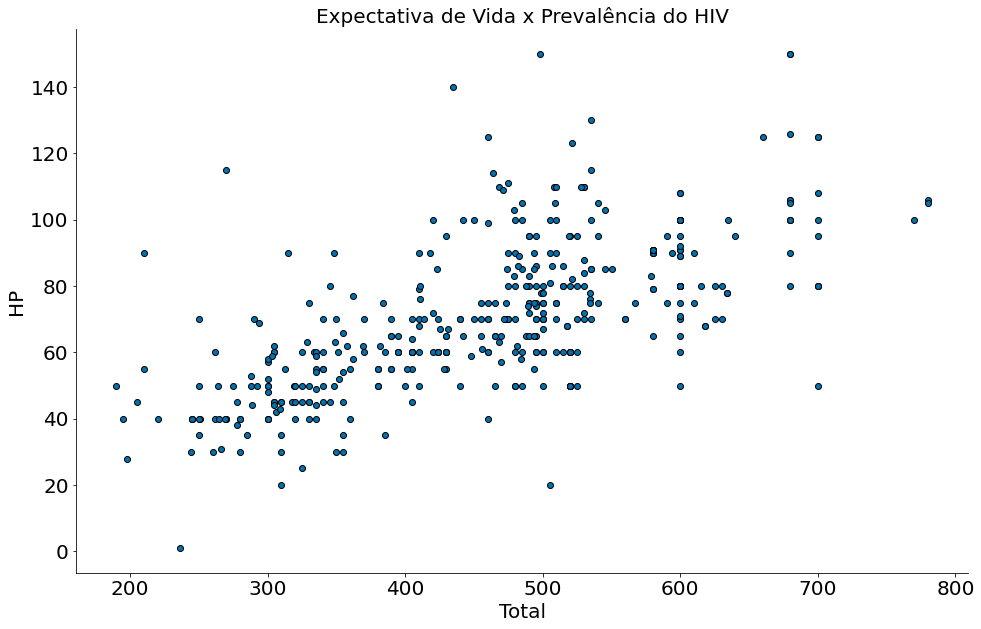

In [ ]:
colx = 'Total'
# colx = 'HP'
# colx = 'Attack'
# colx = 'Defense'
# colx = 'Sp. Atk'
# colx = 'Sp. Def'
# colx = 'Speed'
# colx = 'Generation'
# colx = 'Legendary'

# coly = 'Total'
coly = 'HP'
# coly = 'Attack'
# coly = 'Defense'
# coly = 'Sp. Atk'
# coly = 'Sp. Def'
# coly = 'Speed'

plt.scatter(df.dropna()[colx], df.dropna()[coly], edgecolors='k')
plt.xlabel(colx)
plt.ylabel(coly)
plt.title('Expectativa de Vida x Prevalência do HIV')

despine()

plt.show()

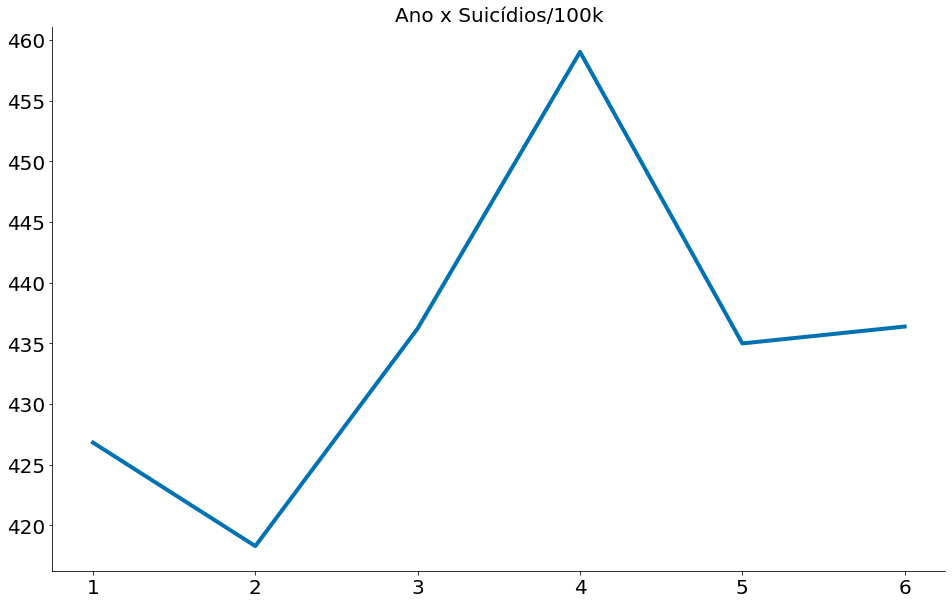

In [ ]:
col = 'Total'
# col = 'HP'
# col = 'Attack'
# col = 'Defense'
# col = 'Sp. Atk'
# col = 'Sp. Def'
# col = 'Speed'
# col = 'Legendary'

dx = df[['Generation', col]].groupby(by='Generation').mean()
x = dx.index
y = dx.values

# plt.bar(x, y[:,0])
plt.plot(dx)
plt.title('Ano x Suicídios/100k')

despine()

plt.show()

R2 grau 1: 0.07390428618873501

R2 grau 2: 0.1077509500842524

R2 grau 3: 0.10777648438203512

R2 grau 4: 0.12500686719230847

R2 grau 5: 0.12713511482197593

R2 grau 6: 0.13123842238179606

R2 grau 7: 0.13137389533163746

R2 grau 8: 0.1399928861816263

R2 grau 9: 0.14002977755804968

R2 grau 10: 0.14098610751378693



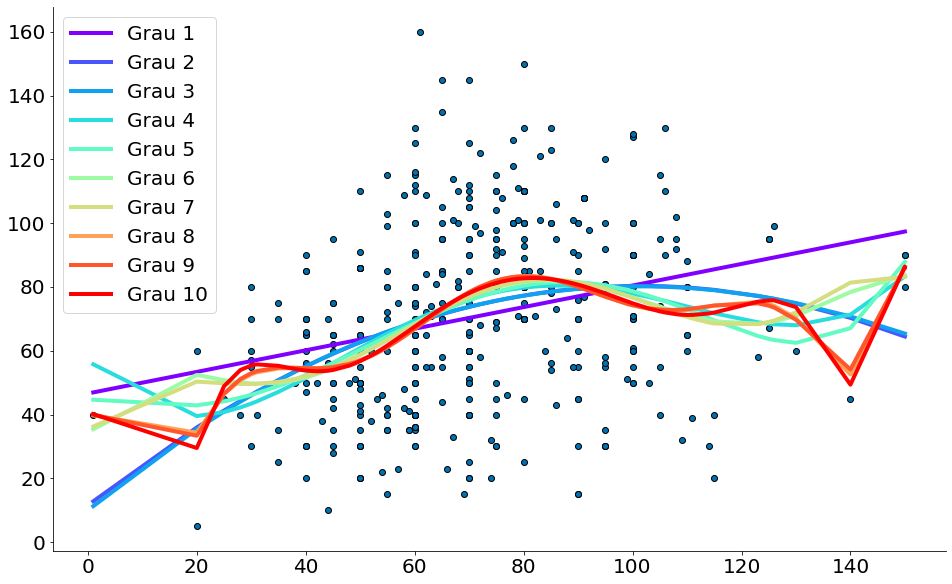

In [ ]:
# colx = 'Total'
colx = 'HP'
# colx = 'Attack'
# colx = 'Defense'
# colx = 'Sp. Atk'
# colx = 'Sp. Def'
# colx = 'Speed'

# coly = 'Total'
# coly = 'HP'
# coly = 'Attack'
# coly = 'Defense'
# coly = 'Sp. Atk'
# coly = 'Sp. Def'
coly = 'Speed'

n_iters = 10

color = iter(cm.rainbow(np.linspace(0, 1, n_iters)))

X = df.dropna()[[colx]]
y = df.dropna()[[coly]]

X_sorted = X.sort_values(by=colx)
y_sorted = y.sort_values(by=coly)

sc = StandardScaler()
for k in range(n_iters):
    poly_features = PolynomialFeatures(degree=k+1, include_bias=False)
    lin_reg = LinearRegression()

    poly_reg_model = Pipeline([
        ('std_scaler', sc),
        ('poly', poly_features),
        ('regressor', lin_reg)
    ])
    
    poly_reg_model.fit(X, y)

    y_hat = poly_reg_model.predict(X_sorted)
    
    c = next(color)
    plt.plot(X_sorted, y_hat, color=c, label='Grau ' + str(k+1))
    # print('Coeficientes:', lin_reg.coef_)
    # print('Intercepto:', lin_reg.intercept_)

    precision = poly_reg_model.score(X, y)

    print('R2 grau', str(k + 1) + ':', precision)
    print()

plt.scatter(X, y, edgecolors='k')

plt.legend()

despine()

plt.show()

In [ ]:
colx = 'GDP per capita'
coly = 'HDI'

X = df.dropna()[[colx]]
y = df.dropna()[[coly]]

X_sorted = X.sort_values(by=colx)
y_sorted = y.sort_values(by=coly)

X_log = np.log(X)
X_log_sorted = np.log(X_sorted)

for k in range(1):
    sc = StandardScaler()

    poly_features = PolynomialFeatures(degree=k+1, include_bias=False)
    linear = LinearRegression()
    lasso = GridSearchCV(Lasso(), cv=3, refit=True, param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]})
    ridge = GridSearchCV(Ridge(), cv=3, refit=True, param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]})
    knn = GridSearchCV(KNeighborsRegressor(), cv=3, refit=True, param_grid={'n_neighbors': [2, 3, 5, 7, 11, 13], 'weights': ['uniform', 'distance']})


    poly_reg_model = Pipeline([
        ('std_scaler', sc),
        ('poly', poly_features),
        ('regressor', linear)
    ])

    poly_reg_model.fit(X_log, y)

    y_hat = poly_reg_model.predict(X_log_sorted)

    plt.plot(X_sorted, y_hat, color='r', label='Log')
    # print('Coeficientes:', lin_reg.coef_)
    # print('Intercepto:', lin_reg.intercept_)

    precision = poly_reg_model.score(X_log, y)

    print('R2:', precision)

plt.scatter(X, y, edgecolors='k')

plt.legend()

despine()

plt.show()

In [ ]:
colx = 'GDP per capita'
coly = 'HDI'

X = np.log(df.dropna()[[colx]])
y = df.dropna()[[coly]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

sc = StandardScaler()

poly_features = PolynomialFeatures(degree=1, include_bias=False)
linear = LinearRegression()
lasso = GridSearchCV(Lasso(), cv=3, refit=True, param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]})
ridge = GridSearchCV(Ridge(), cv=3, refit=True, param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]})
knn = GridSearchCV(KNeighborsRegressor(), cv=3, refit=True, param_grid={'n_neighbors': [2, 3, 5, 7, 11, 13], 'weights': ['uniform', 'distance']})

poly_reg_model = Pipeline([
    ('std_scaler', sc),
    ('poly', poly_features),
    ('regressor', knn)
])

poly_reg_model.fit(X_train, y_train)

r2_values0 = bootstrap_score(X_train, y_train, poly_reg_model, n=1000)
r2_values1 = bootstrap_score(X_test, y_test, poly_reg_model, n=1000)

LI0 = np.percentile(r2_values0, 2.5)
LS0 = np.percentile(r2_values0, 97.5)
M0 = r2_values0.mean()

LI1 = np.percentile(r2_values1, 2.5)
LS1 = np.percentile(r2_values1, 97.5)
M1 = r2_values1.mean()

ymin = 0

maior = []

n, bins, patches = plt.hist(r2_values0, bins=30, label='Treino', edgecolor='k')

maior.append(n.max())

n, bins, patches = plt.hist(r2_values1, bins=30, label='Teste', edgecolor='k')

maior.append(n.max())

maior = np.max(maior)

plt.vlines(LI0, ymin, maior, linestyles='--', label='IC do R2', color='m')
plt.vlines(LS0, ymin, maior, linestyles='--', edgecolor='m')
plt.vlines(M0, ymin, maior, linestyles='--', label='Média do Treino', color='r')
plt.vlines(LI1, ymin, maior, linestyles='--', label='IC do R2', color='y')
plt.vlines(LS1, ymin, maior, linestyles='--', edgecolor='y')
plt.vlines(M1, ymin, maior, linestyles='--', label='Média do Teste', color='k')

plt.xlabel('R2')
plt.title('ICs do R2 da Regressão Linear nos Grupos de Treino e de Teste')

plt.legend()

despine()

plt.show()


# 6. Separação dos Grupos

In [ ]:
df.columns

Regressão 100k (talvez GDP p/c ou até HDI)

Class Sex, Age, Gen

## 1. Regressão em Suicides/100k

Separamos os grupos de treino e teste. Escolhemos deixar as duas colunas que contém outras informações sobre o GDP porque uma delas é relativa (e também depende do tamanho da população) e a outra não diz nada sobre o valor absoluto do GDP (por mais que seja mais difícil um GDP já alto crescer).

### 1. Versão com dropna

In [ ]:
X = df.copy()
X = X.dropna()
y = X['Suicides/100k']

X = X.drop(['Suicides/100k', 'Country'], axis=1)

### 2. Versão com fillna

In [ ]:
# X = df.copy()
# X = X.drop(['Suicides/100k', 'Country'], axis=1)
# X['HDI'] = X['HDI'].fillna(X['HDI'].mean())

# y = df['Suicides/100k']

### 3. Continuação

In [ ]:
non_strings = []

for i, col in enumerate(X.columns):
    if X.dtypes[i] != np.dtype('object'):
        non_strings.append(col)

In [ ]:
df.columns

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

non_strings = non_strings[:-1]
mean_train = X_train[non_strings].mean()
std_train = X_train[non_strings].std(ddof=1)

Z_train = X_train.copy()
Z_train[non_strings] = Z_train[non_strings] - mean_train
Z_train[non_strings] = Z_train[non_strings] / std_train

Z_test = X_test.copy()
Z_test[non_strings] = Z_test[non_strings] - mean_train
Z_test[non_strings] = Z_test[non_strings] / std_train

Transformamos as colunas categóricas em numéricas.

In [ ]:
D_train = pd.get_dummies(Z_train, prefix='', prefix_sep='')
D_test = pd.get_dummies(Z_test, prefix='', prefix_sep='')

# 7. Fit dos Modelos

Usamos o SKLearn, de novo, para fazer a Regressão Linear Múltipla e mostramos os coeficientes para cada coluna do DataFrame de teste.



In [ ]:
linear = LinearRegression(fit_intercept=False)
lasso = GridSearchCV(Lasso(fit_intercept=False), cv=3, refit=True, param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]})
ridge = GridSearchCV(Ridge(fit_intercept=False), cv=3, refit=True, param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]})
knn = GridSearchCV(KNeighborsRegressor(), cv=3, refit=True, param_grid={'n_neighbors': [2, 3, 5, 7, 11, 13], 'weights': ['uniform', 'distance']})

Fazemos, então o fit de cada modelo e mostramos seu Coeficiente de Determinação.

In [ ]:
linear = linear.fit(D_train, y_train)
linear.score(D_train, y_train)

In [ ]:
lasso = lasso.fit(D_train, y_train)
lasso.score(D_train, y_train)

Nos casos do Lasso, Ridge e KNN mostramos também os melhores hiper-parâmetros.

In [ ]:
lasso.best_params_

In [ ]:
ridge = ridge.fit(D_train, y_train)
ridge.score(D_train, y_train)

In [ ]:
ridge.best_params_

In [ ]:
knn = knn.fit(D_train, y_train)
knn.score(D_train, y_train)

In [ ]:
knn.best_params_

# 8. Avaliação dos Modelos

Para fazer a avaliação dos diferentes modelos usados nesse notebook, iremos utilizar o Erro Médio Quadrado. Quanto maior o erro, pior é o modelo, o ideal é um erro 0.

## 2. Avaliação Usando o Grupo de Teste

Agora uma avaliação com os dados do grupo de teste, simulando, assim, uma situação do mundo real, na qual não sabemos a resposta de antemão.

Primeiro Z-normalizamos os dados do teste com a média e o desvio padrão dos dados de treino, de forma a não utilizar nenhuma informação do treino, no teste.

### 1. Regressão Linear no Grupo de Teste

Fazemos uma comparação do grupo de treino e o de teste, usando bootstrap.

Como esperado, o IC do grupo de teste é bem maior, e no caso da Regressão Linear, a performance não foi tão boa no grupo de teste.

In [ ]:
r2_values0 = bootstrap_score(D_train, y_train, linear)
r2_values1 = bootstrap_score(D_test, y_test, linear)

LI0 = np.percentile(r2_values0, 2.5)
LS0 = np.percentile(r2_values0, 97.5)
LI1 = np.percentile(r2_values1, 2.5)
LS1 = np.percentile(r2_values1, 97.5)

ymin = 0

maior = []

n, bins, patches = plt.hist(r2_values0, bins=30, label='Treino', edgecolor='k')

maior.append(n.max())

n, bins, patches = plt.hist(r2_values1, bins=30, label='Teste', edgecolor='k')

maior.append(n.max())

maior = np.max(maior)

plt.vlines(LI0, ymin, maior, linestyles='--', label='IC do R2', color='m')
plt.vlines(LS0, ymin, maior, linestyles='--', edgecolor='m')
plt.vlines(LI1, ymin, maior, linestyles='--', label='IC do R2', color='y')
plt.vlines(LS1, ymin, maior, linestyles='--', edgecolor='y')

plt.xlabel('R2')
plt.title('ICs do R2 da Regressão Linear nos Grupos de Treino e de Teste')

plt.legend()

despine()

plt.show()

### 2. Lasso no Grupo de Teste

O IC do Lasso aumenta bastante também, e ele piora em relação à Regressão Linear.

In [ ]:
r2_values0 = bootstrap_score(D_train, y_train, lasso)
r2_values1 = bootstrap_score(D_test, y_test, lasso)

LI0 = np.percentile(r2_values0, 2.5)
LS0 = np.percentile(r2_values0, 97.5)
LI1 = np.percentile(r2_values1, 2.5)
LS1 = np.percentile(r2_values1, 97.5)

ymin = 0

maior = []

n, bins, patches = plt.hist(r2_values0, bins=30, label='Treino', edgecolor='k')

maior.append(n.max())

n, bins, patches = plt.hist(r2_values1, bins=30, label='Teste', edgecolor='k')

maior.append(n.max())

maior = np.max(maior)

plt.vlines(LI0, ymin, maior, linestyles='--', label='IC do R2', color='m')
plt.vlines(LS0, ymin, maior, linestyles='--', edgecolor='m')
plt.vlines(LI1, ymin, maior, linestyles='--', label='IC do R2', color='y')
plt.vlines(LS1, ymin, maior, linestyles='--', edgecolor='y')

plt.xlabel('R2')
plt.title('ICs do R2 do Lasso nos Grupos de Treino e de Teste')

plt.legend()

despine()

plt.show()

### 3. Ridge no Grupo de Teste

Já o Ridge melhora bastante, e mostra que é bom generalizador, já que seus ICs são os mais parecidos em tamanho, até agora.

In [ ]:
r2_values0 = bootstrap_score(D_train, y_train, ridge)
r2_values1 = bootstrap_score(D_test, y_test, ridge)

LI0 = np.percentile(r2_values0, 2.5)
LS0 = np.percentile(r2_values0, 97.5)
LI1 = np.percentile(r2_values1, 2.5)
LS1 = np.percentile(r2_values1, 97.5)

ymin = 0

maior = []

n, bins, patches = plt.hist(r2_values0, bins=30, label='Treino', edgecolor='k')

maior.append(n.max())

n, bins, patches = plt.hist(r2_values1, bins=30, label='Teste', edgecolor='k')

maior.append(n.max())

maior = np.max(maior)

plt.vlines(LI0, ymin, maior, linestyles='--', label='IC do R2', color='m')
plt.vlines(LS0, ymin, maior, linestyles='--', edgecolor='m')
plt.vlines(LI1, ymin, maior, linestyles='--', label='IC do R2', color='y')
plt.vlines(LS1, ymin, maior, linestyles='--', edgecolor='y')

plt.xlabel('R2')
plt.title('ICs do R2 do Ridge nos Grupos de Treino e de Teste')

plt.legend()

despine()

plt.show()

### 4. KNN no Grupo de Teste

Como se esperava, o KNN decorou os dados de treino e não sabe generalizar, se mostrando pior que a Regressão Linear que é bem mais simples e rápida.

O gráfico foi cortado para permitir a visualização da distribuição do MSE do grupo de teste.

In [ ]:
r2_values0 = bootstrap_score(D_train, y_train, knn)
r2_values1 = bootstrap_score(D_test, y_test, knn)

LI0 = np.percentile(r2_values0, 2.5)
LS0 = np.percentile(r2_values0, 97.5)
LI1 = np.percentile(r2_values1, 2.5)
LS1 = np.percentile(r2_values1, 97.5)

ymin = 0

maior = []

n, bins, patches = plt.hist(r2_values0, bins=30, label='Treino', edgecolor='k')

maior.append(n.max())

n, bins, patches = plt.hist(r2_values1, bins=30, label='Teste', edgecolor='k')

maior.append(n.max())

maior = np.max(maior)

plt.vlines(LI0, ymin, maior, linestyles='--', label='IC do R2', color='m')
plt.vlines(LS0, ymin, maior, linestyles='--', edgecolor='m')
plt.vlines(LI1, ymin, maior, linestyles='--', label='IC do R2', color='y')
plt.vlines(LS1, ymin, maior, linestyles='--', edgecolor='y')

plt.xlabel('R2')
plt.title('ICs do R2 do KNN nos Grupos de Treino e de Teste')

plt.legend()

despine()

plt.show()

## 3. Melhor Modelo e Parâmetros

O Ridge se mostrou o melhor modelo para generalizar o aprendizado obtido com os dados de treino.

# 9. Conclusão <a name="concl"></a>

O projeto criou oportunidades para o aprendizado de várias técnicas, conceitos e ferramentas do arcabouço de Ciência de Dados. Além do mais, foi possível perceber a importância de apresentar os dados de forma a aumentar a legibilidade deles pelo leitor.

Autor: Lucas S. Teles